In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Load the model and tokenizer
model_path = "/content/drive/MyDrive/data-for-clinical-note-summarizer/fine_tuned_bio_bart"
model = BartForConditionalGeneration.from_pretrained(model_path)
tokenizer = BartTokenizer.from_pretrained(model_path)

print("Model and tokenizer loaded successfully.")


In [1]:
!pip install safetensors gdown


In [3]:
import gdown

# Replace FILE_ID with the actual file ID from your Google Drive link
gdown.download('https://drive.google.com/file/d/1-3hQPZ9DINLM3x_aBbDPBIeYyXRcLP9N/view?usp=sharing', 'model.safetensors', quiet=False)


Downloading...
From: https://drive.google.com/file/d/1-3hQPZ9DINLM3x_aBbDPBIeYyXRcLP9N/view?usp=sharing
To: /kaggle/working/model.safetensors
91.8kB [00:00, 3.84MB/s]


'model.safetensors'

In [ ]:
# Save the modified DataFrame to a new CSV file (optional)
output_file_path = "/content/cleaned_output_dropped.csv"
df.to_csv(output_file_path, index=False)


In [1]:
import pandas as pd

In [2]:
# Load dataset
data = pd.read_csv('/kaggle/input/pubmed/cleaned_output_dropped.csv')  
train_df, val_df, test_df = (
    data.sample(frac=0.8, random_state=42),
    data.sample(frac=0.1, random_state=42),
    data.sample(frac=0.1, random_state=42)
)



In [3]:
from datasets import Dataset, DatasetDict
# Convert to Hugging Face Dataset
def load_dataset(df):
    return Dataset.from_pandas(df[['abstract_cleaned', 'paragraphs_cleaned']])

datasets = DatasetDict({
    "train": load_dataset(train_df),
    "validation": load_dataset(val_df),
    "test": load_dataset(test_df)
})

In [6]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer


model_name = "GanjinZero/biobart-base"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/279M [00:00<?, ?B/s]

In [7]:
# Tokenization
def preprocess_data(examples):
    inputs = tokenizer(
        examples['paragraphs_cleaned'], max_length=512, truncation=True, padding='max_length'
    )
    targets = tokenizer(
        examples['abstract_cleaned'], max_length=150, truncation=True, padding='max_length'
    )
    inputs['labels'] = targets['input_ids']
    return inputs

# Apply tokenization
tokenized_datasets = datasets.map(preprocess_data, batched=True, remove_columns=['paragraphs_cleaned', 'abstract_cleaned'])

# Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)


Map:   0%|          | 0/28291 [00:00<?, ? examples/s]

Map:   0%|          | 0/3536 [00:00<?, ? examples/s]

Map:   0%|          | 0/3536 [00:00<?, ? examples/s]

In [8]:
import torch
from transformers import TrainingArguments, Trainer

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure that the model is on the correct device
model = model.to(device)



In [9]:
print(device)

cuda


In [10]:
from transformers import Trainer

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bio_bart_summarizer",  # Directory to save checkpoints
    evaluation_strategy="epoch",        # Evaluate after every epoch
    save_strategy="epoch",               # Save model checkpoints after every epoch
    logging_dir="./logs",                # Directory for logging
    logging_steps=50,                    # Log every 50 steps
    per_device_train_batch_size=8,      # Batch size for training
    per_device_eval_batch_size=8,       # Batch size for evaluation
    gradient_accumulation_steps=2,      # Accumulate gradients to simulate a larger batch size
    learning_rate=3e-5,                  # Learning rate
    num_train_epochs=10,                # Number of epochs
    weight_decay=0.01,                  # Weight decay for regularization
    save_total_limit=2,                 # Save only the last 2 checkpoints
    load_best_model_at_end=True,         # Load the best model at the end of training
    report_to=["none"],                  # Disable WandB logging if not needed
    fp16=True,                           # Enable mixed precision training for faster training and lower memory usage
    dataloader_num_workers=4,            # Number of subprocesses to use for data loading
)


# Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train the Model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
0,2.778000,2.574113
2,2.603100,2.380080
4,2.434500,2.273106
6,2.428400,2.207037
8,2.345600,2.174011
9,2.342100,2.170057


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Some non-default generation parameters are set in the model config. These sh

TrainOutput(global_step=8840, training_loss=2.50933350783128, metrics={'train_runtime': 17574.1551, 'train_samples_per_second': 16.098, 'train_steps_per_second': 0.503, 'total_flos': 8.620545507065856e+16, 'train_loss': 2.50933350783128, 'epoch': 9.994347088750708})

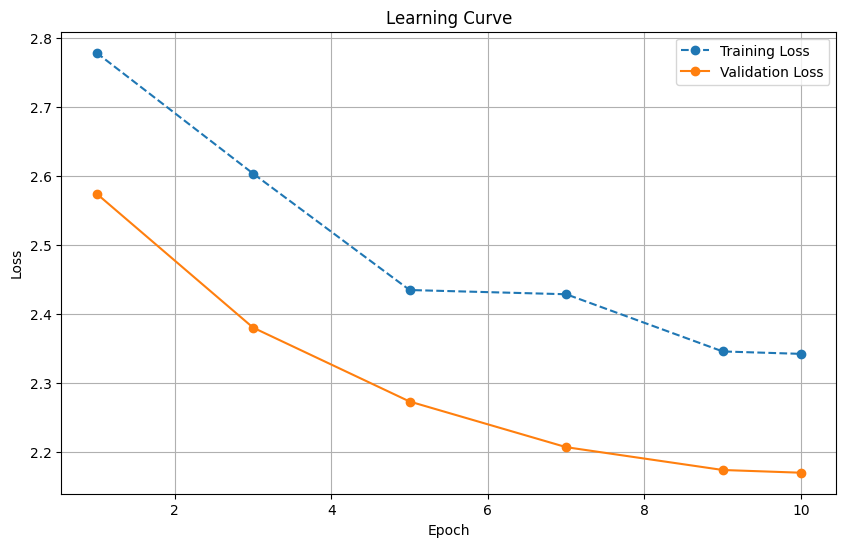

In [16]:
import matplotlib.pyplot as plt

# Data for the plot
epochs = [1, 3, 5, 7, 9, 10]
training_loss = [2.778000, 2.603100, 2.434500, 2.428400, 2.345600, 2.342100]
validation_loss = [2.574113, 2.380080, 2.273106, 2.207037, 2.174011, 2.170057]

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label="Training Loss", marker="o", linestyle="--")
plt.plot(epochs, validation_loss, label="Validation Loss", marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()


In [15]:

%pwd
%ls

input/  lib/  working/
